Different paths on the tree with NN, to see if energies are still proportional

In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
import numpy as np
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from adabmDCA.sampling import get_sampler
import random

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [2]:
import importlib
importlib.reload(selex_dca)

<module 'selex_dca' from '/home/scrotti/Aptamer2025py/experiments/../selex_dca.py'>

In [3]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N", "R02F", "R02S", "R02SF"]

In [4]:
device = torch.device("cpu")
dtype = torch.float32

Extract sequences and compute 1st and 2nd moment statistics

In [5]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id, device=torch.device("cpu"))
    sequences.append(s)
    print(f"finished {round_id}")

finished ARN
finished R01
finished R02N
finished R02F
finished R02S
finished R02SF


In [6]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)

In [7]:
paths = [np.array([1, 2]), np.array([1, 3]), np.array([1, 4]), np.array([1, 5])]
n_paths = len(paths)
path_labels = ['norm A, norm W', 'fast A, norm W', 'norm A, high W', 'fast A, high W']

In [8]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[utils.frequences_from_sequences(seq, pseudo_count=0, dtype=dtype) for seq in sequences])

fi = torch.stack(freq_single_tuple).to(device)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple).to(device)     # n_rounds, L, q, L, q

n_rounds, L, q = fi.size()

In [9]:
sequences_oh_paths = [[sequences_oh[pp] for pp in p] for p in paths]
fi_paths = [fi[p] for p in paths]
total_reads_paths = [total_reads[p] for p in paths]

In [10]:
def mlp(n_hidden, dtype, device):
    return torch.nn.Sequential(
        torch.nn.Linear(L*q, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, 1)
    ).to(dtype=dtype, device=device)

def linear(dtype, device):
    return torch.nn.Linear(L*q, 1).to(dtype=dtype, device=device)

In [ ]:
models_paths = []
callbacks_paths = []
chains_paths = []

n_hidden = 50
max_epochs = 1000
weight_decay = 1e-2

for i in range(len(paths)):
    tr = tree.Tree()
    tr.add_node(-1)
    tr.add_node(0)
    selected_modes = torch.BoolTensor([[1],[1]])
    h = torch.randn(L, q, device=device, dtype=dtype)
    J_ = torch.randn(L*q, L*q, dtype=dtype) / torch.sqrt(torch.Tensor([L]).to(dtype=dtype))
    J_ = J_ + J_.t()
    J = J_.reshape(L, q, L, q)
    Ns0 = energy_models.Potts(J, h)
    nn = energy_models.GenericEnergyModel(mlp(n_hidden, dtype, device))
    ps = selex_distribution.MultiModeDistribution(nn, normalized=False)
    model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)
    sequences_oh_path = sequences_oh_paths[i]
    batch_size = 10**6
    data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) 
                    for seq_oh in sequences_oh_path]
    n_rounds = len(data_loaders) 
    n_chains = 10**4
    chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
    log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)
    callbacks = [callback.ConvergenceMetricsCallback()]
    
    n_sweeps = 10
    lr = 0.001
    target_pearson = 1
    
    training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, 
                   callbacks=callbacks, log_weights=log_weights, 
                   optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay))
    
    models_paths.append(model)
    callbacks_paths.append(callbacks[0])
    chains_paths.append(chains)

 0.00%[                                          ] Epoch: 0/1000 [00:00, ?it/s]

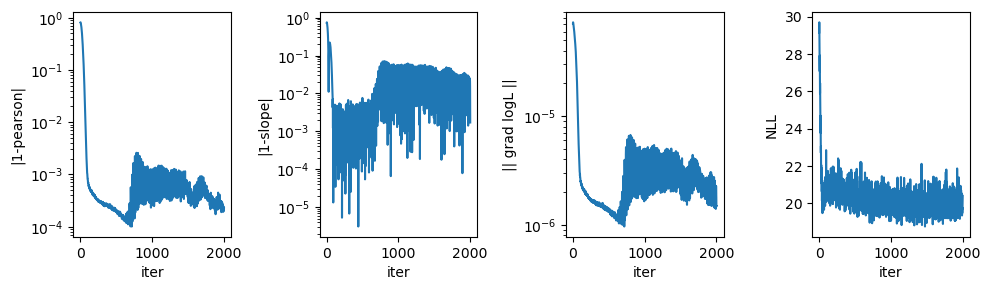

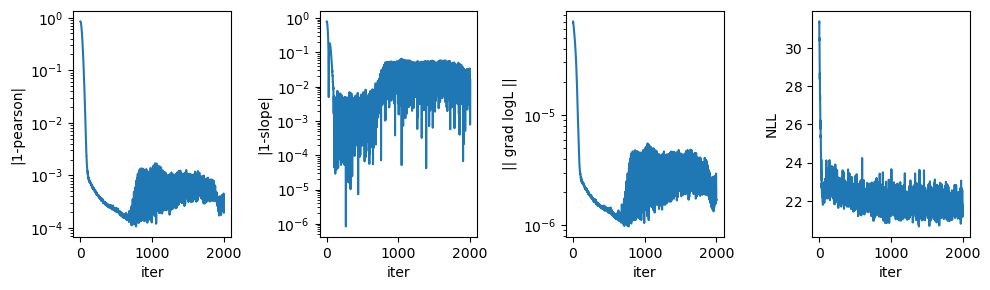

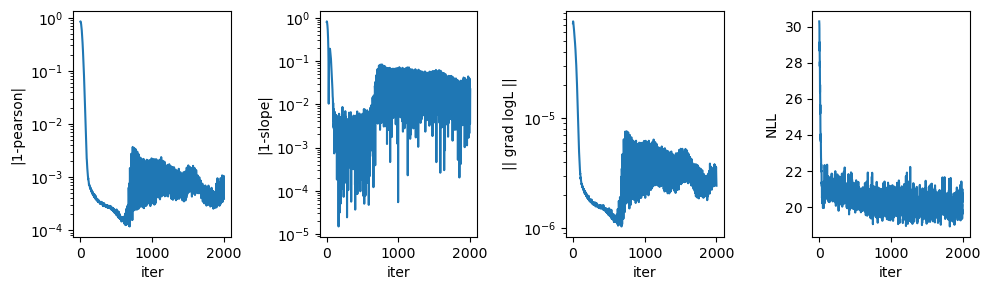

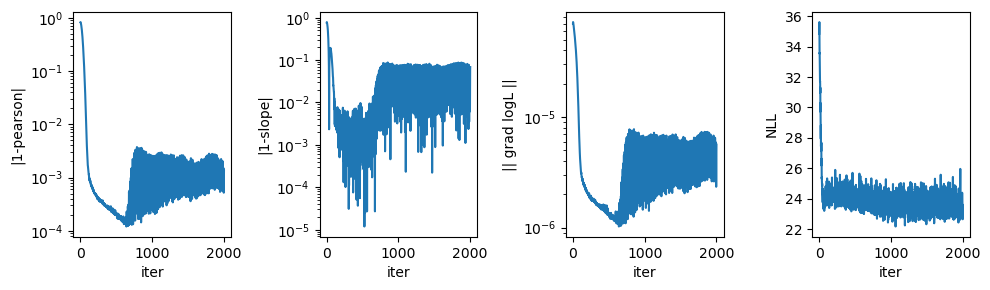

In [20]:
[cb.plot() for cb in callbacks_paths];

In [ ]:
X = sequences_oh[0]

In [ ]:
logNs0_paths = []
for i in range(len(paths)):
    logNs0 = models_paths[i].round_zero.compute_energy(X).detach()
    logNs0_paths.append(logNs0)
    print(f"finished {i+1}-th path")

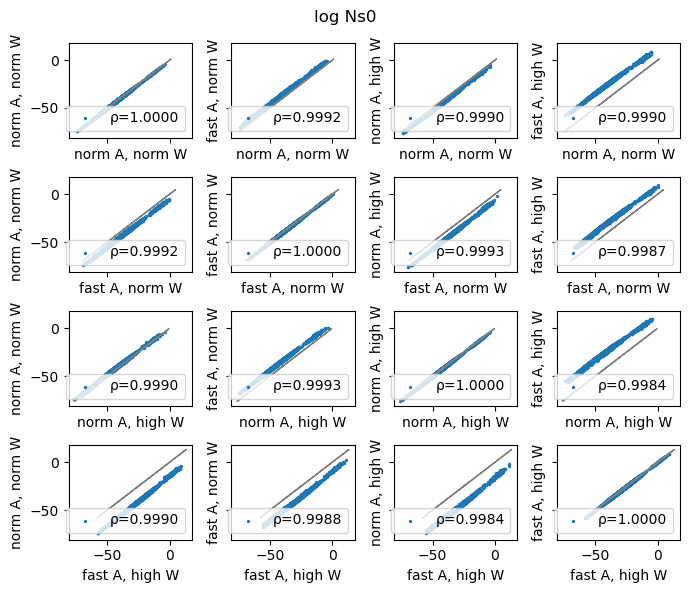

In [21]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(7,6)
                        )
N = 10**4

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logNs0_paths[i]
        y = logNs0_paths[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('log Ns0')
fig.tight_layout()

In [ ]:
logps_paths = []
for i in range(len(paths)):
    logps = models_paths[i].selection.modes[0].compute_energy(X).detach()
    logps_paths.append(logps)
    print(f"finished {i+1}-th path")

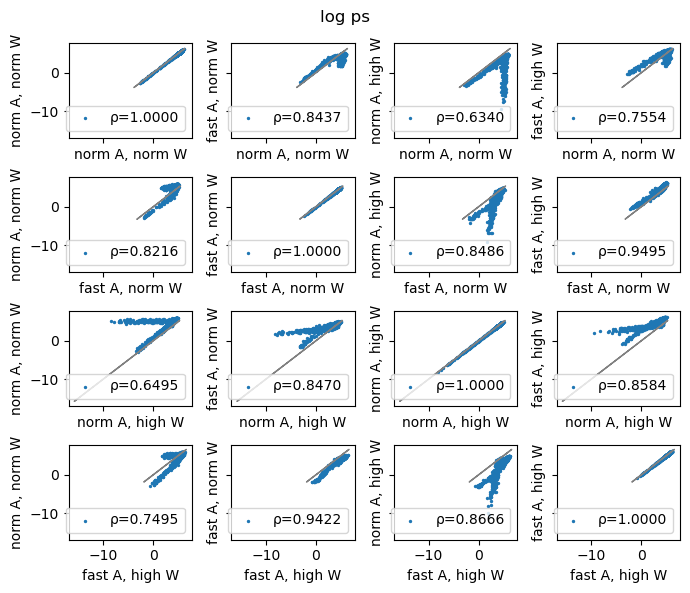

In [22]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(7,6)
                        )
N = 10**4

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logps_paths[i]
        y = logps_paths[j]
        idx = random.sample(range(len(x)), min(N, len(x)))
        rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        ax.legend(loc='lower right')
        ax.plot(x, x, color='gray', lw=1)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('log ps')
fig.tight_layout()

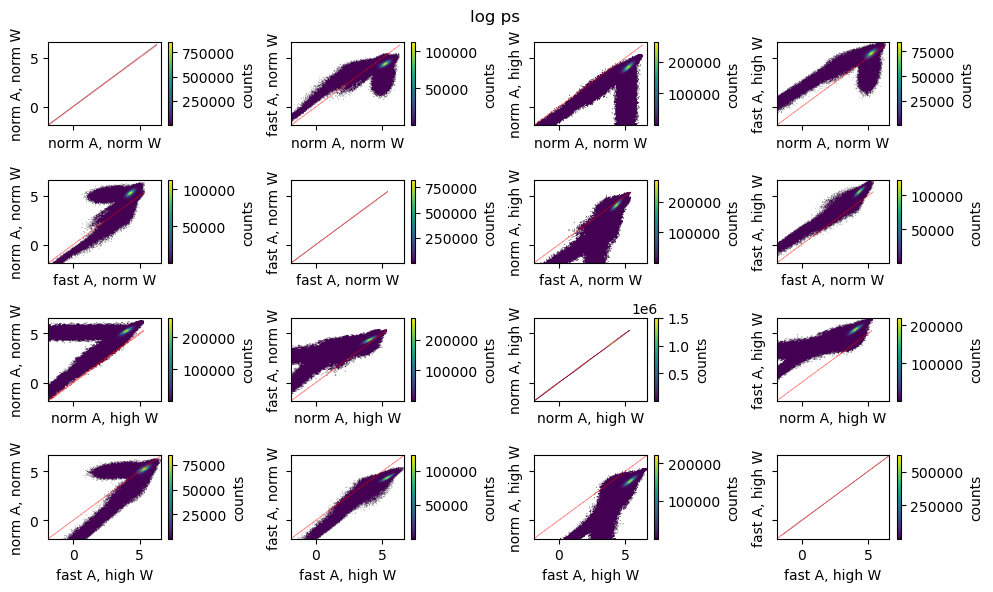

In [23]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(10,6)
                        )
# N = 10**5

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logps_paths[i]
        y = logps_paths[j]
        # idx = random.sample(range(len(x)), min(N, len(x)))
        # rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        # ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        # ax.legend(loc='lower right')
        # ax.plot(x, x, color='gray', lw=1)
        ax.plot(x, x, color='r', lw=0.5, alpha=0.4)
        h, xedges, yedges = np.histogram2d(x, y, bins=200)
        cmap = plt.cm.viridis.copy()
        cmap.set_under(alpha=0)
        im = ax.imshow(
            h.T, origin="lower", cmap=cmap, vmin=0.001,
            extent=[
                xedges[0], xedges[-1],
                yedges[0], yedges[-1],
            ],
            aspect="auto",
        )
        fig.colorbar(im, label="counts", ax=ax)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
fig.suptitle('log ps')
fig.tight_layout()

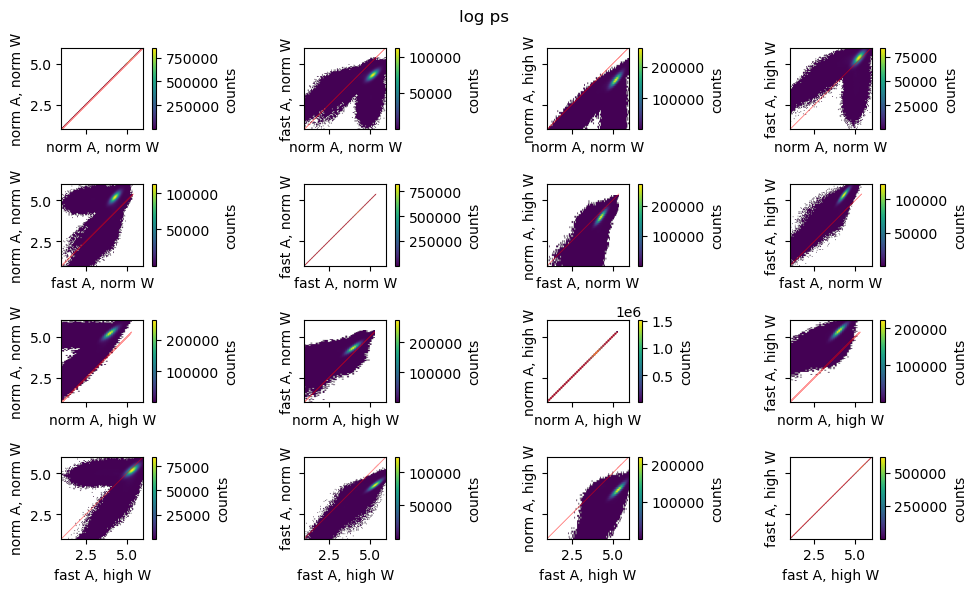

In [24]:
fig, axes = plt.subplots(n_paths, n_paths, 
                         sharex=True, sharey=True, figsize=(10,6)
                        )
# N = 10**5

for i in range(n_paths):
    for j in range(n_paths):
        ax = axes[i,j]
        x = logps_paths[i]
        y = logps_paths[j]
        # idx = random.sample(range(len(x)), min(N, len(x)))
        # rho = torch.corrcoef(torch.stack((x[idx],y[idx])))[0,1].item()
        # ax.scatter(x[idx], y[idx], s=2, label=f'ρ={rho:.4f}')
        # ax.legend(loc='lower right')
        # ax.plot(x, x, color='gray', lw=1)
        ax.plot(x, x, color='r', lw=0.5, alpha=0.4)
        h, xedges, yedges = np.histogram2d(x, y, bins=200)
        cmap = plt.cm.viridis.copy()
        cmap.set_under(alpha=0)
        im = ax.imshow(
            h.T, origin="lower", cmap=cmap, vmin=0.001,
            extent=[
                xedges[0], xedges[-1],
                yedges[0], yedges[-1],
            ]
        )
        fig.colorbar(im, label="counts", ax=ax)
        ax.set_xlabel(path_labels[i])
        ax.set_ylabel(path_labels[j])
        ax.set_xlim((1,6))
        ax.set_ylim((1,6))
fig.suptitle('log ps')
fig.tight_layout()